In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('./data/cleaned_kc_house_data.csv')

## Analyzing Variables of High Value Houses

In this notebook, we analyze and visualize relationships between variables of high-value houses, to understand how those variables affect variation in price, in order to answer our business problem. We defined high value houses as any house with a sale price above \\ $800,000. We chose this number because it represents houses that a large enough quantity of data points not to be skewed too severely by the biggest outliers, while also being distant enough from the whole dataset to behave similarly. For reference, the high value sample comprises about 3,000 houses whose mean sale price is nearly double the average sale price of the full dataset of houses sold in 2014-15. 

In [3]:
#create new df for houses above $800,000
target_df = df.loc[df['price'] >= 800000]

In [4]:
target_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_basment_calc,grades,waterfront,condition
count,3.000000e+03,3000.000000,3000.00000,3000.000000,3.000000e+03,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1.203345e+06,3.966667,2.89775,3372.903000,2.289503e+04,1.763000,2822.596333,1973.708333,170.004667,98070.790667,47.619777,-122.210106,2843.929333,17315.756000,550.306667,6.290333,0.037333,2.457000
std,5.484658e+05,0.886840,0.83332,1092.722341,6.061375e+04,0.484158,1040.455704,32.524594,557.882106,53.376804,0.066990,0.125036,820.043668,37247.324103,631.849823,1.215126,0.189609,0.692082
min,8.000000e+05,1.000000,1.00000,1050.000000,6.090000e+02,1.000000,710.000000,1900.000000,0.000000,98001.000000,47.233200,-122.514000,900.000000,977.000000,0.000000,3.000000,0.000000,0.000000
25%,8.750000e+05,3.000000,2.50000,2650.000000,6.000000e+03,1.500000,2010.000000,1951.000000,0.000000,98029.000000,47.572350,-122.303000,2230.000000,5777.250000,0.000000,5.000000,0.000000,2.000000
50%,9.986500e+05,4.000000,2.75000,3240.000000,9.690500e+03,2.000000,2700.000000,1983.000000,0.000000,98065.000000,47.628700,-122.214000,2830.000000,9490.000000,355.000000,6.000000,0.000000,2.000000
75%,1.320000e+06,4.000000,3.50000,3920.000000,1.667500e+04,2.000000,3480.000000,2001.250000,0.000000,98112.000000,47.665100,-122.122750,3390.000000,14841.250000,1000.000000,7.000000,0.000000,3.000000
max,7.700000e+06,10.000000,8.00000,13540.000000,1.024068e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.776400,-121.731000,6210.000000,871200.000000,4820.000000,10.000000,1.000000,4.000000


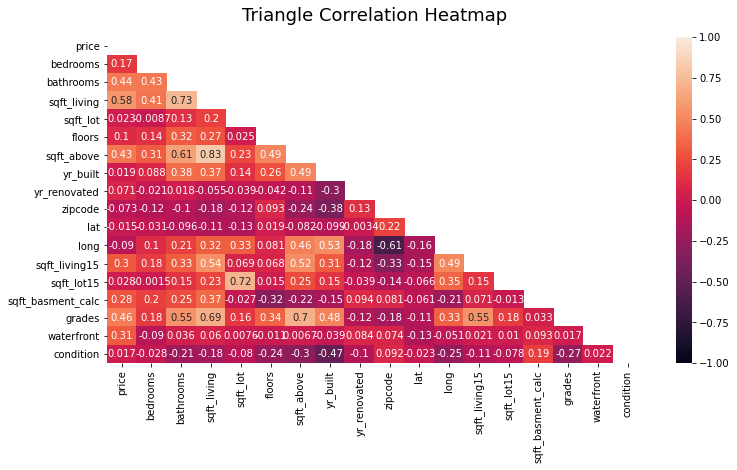

In [5]:
plt.figure(figsize=(12,6))
mask = np.triu(np.ones_like(target_df.corr(), dtype=bool))
heatmap = sns.heatmap(target_df.corr(), mask=mask, vmin=-1, vmax=1, annot = True);
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

**Location Analysis**

Because location is difficult to explain with our data, the first thing we are interested in visualizing is the geographical distribution of all houses compared to that of high value houses.

''

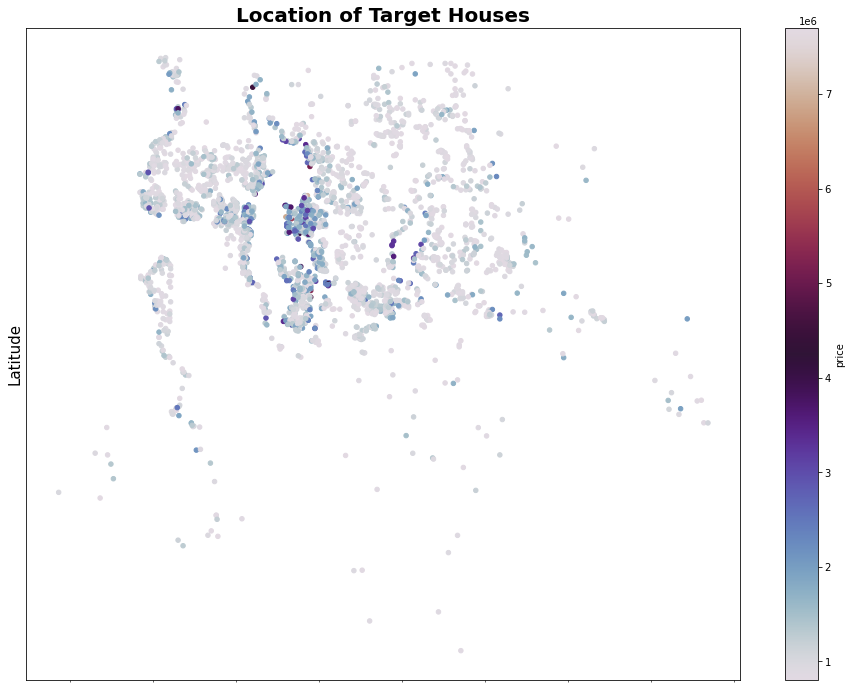

In [6]:
target_df.plot(kind = 'scatter', x='long', y='lat', figsize=(16,12), 
        c= 'price', cmap = 'twilight')
plt.title('Location of Target Houses', fontsize =20, weight = 'bold')
plt.xlabel('Longitude', fontsize =15)
plt.ylabel('Latitude', fontsize =15)


plt.xticks([])
plt.yticks([])

;

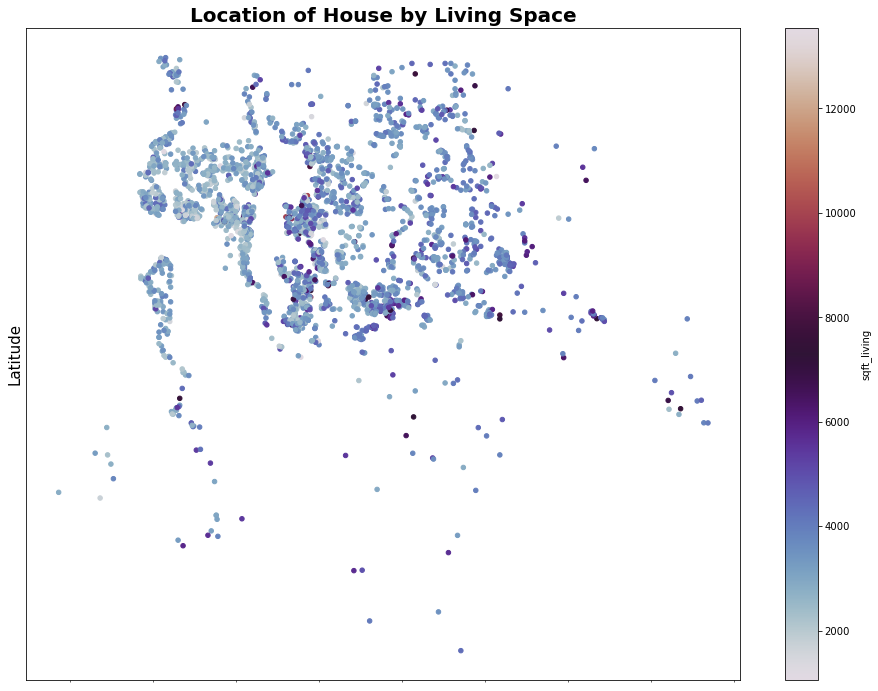

In [7]:
target_df.plot(kind = 'scatter', x='long', y='lat', figsize=(16,12), 
        c= 'sqft_living', cmap = 'twilight')
plt.title('Location of House by Living Space', fontsize =20, weight = 'bold')
plt.ylabel('Latitude', fontsize =15)
plt.xlabel('Longitude', fontsize =15)

plt.xticks([])
plt.yticks([]);

We see a distinct concentration of high value houses near the center of the map and investigate a map of King County. This area appears to generally surround Seattle, so we choose to look more closely at how that group of locations behave relative to one another.

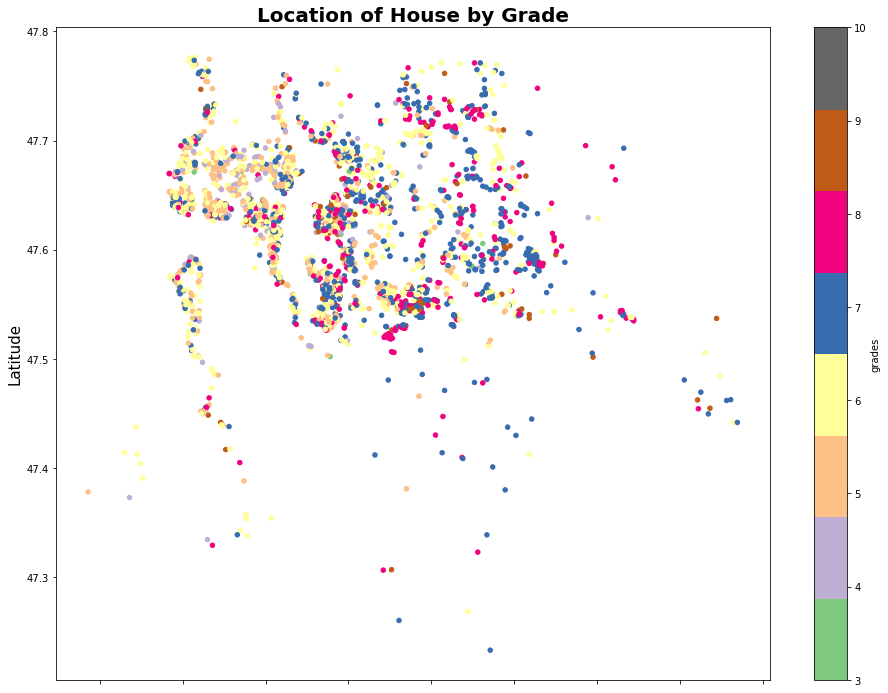

In [8]:
target_df.plot(kind = 'scatter', x='long', y='lat', figsize=(16,12), 
        c= 'grades', cmap = 'Accent')
plt.title('Location of House by Grade', fontsize =20, weight = 'bold')
plt.ylabel('Latitude', fontsize =15)
plt.xlabel('Longitude', fontsize =15);

Based on this visualization grades 5 and 6 seem to be clustered closer to Seattle while higher grades are located more in the eastern part of the county. Because we know the relationship between sqft_living and grade, we suspect that houses in Seattle are smaller than houses outside of Seattle, and we create groups to check this assumption.

We create a dataframe that comprises houses inside Seattle's general coordinates, as well as houses outside. For houses outside, we omit coastal houses, which behave similarly to houses in the Seattle group in terms of grade and sale price.

In [9]:
seattle = target_df.loc[(target_df['long'] <= -122.2) & (target_df['lat'] >= 47.6)]

In [10]:
outside = target_df.loc[target_df['long'] >= -122.2]

We look at the distribution of price and square feet for the houses in these groups. The Seattle group is smaller and more expensive on average. Because sqft_living is our single best explanatory variable of price, and the smaller houses in the Seattle group cost more than the bigger houses in the Outside group, we can see why our r-squared value would be lower for this subset of high value houses than the entire set of houses sold in '14-15.

In [11]:
seattle['price'].describe()

count    1.247000e+03
mean     1.318553e+06
std      6.658068e+05
min      8.000000e+05
25%      8.999750e+05
50%      1.100000e+06
75%      1.480000e+06
max      7.700000e+06
Name: price, dtype: float64

In [12]:
outside['price'].describe()

count    1.288000e+03
mean     1.077051e+06
std      3.675764e+05
min      8.000000e+05
25%      8.550000e+05
50%      9.459000e+05
75%      1.150000e+06
max      4.210000e+06
Name: price, dtype: float64

In [13]:
seattle['sqft_living'].describe()

count     1247.000000
mean      3070.947073
std       1108.631708
min       1050.000000
25%       2360.000000
50%       2900.000000
75%       3590.000000
max      12050.000000
Name: sqft_living, dtype: float64

In [14]:
outside['sqft_living'].describe()

count     1288.000000
mean      3682.016304
std       1007.982645
min       1180.000000
25%       3050.000000
50%       3560.000000
75%       4150.000000
max      13540.000000
Name: sqft_living, dtype: float64

We calculate the price per square foot of both groups and compare them.

In [15]:
seattle_price_space = seattle['sqft_living'].sum()/seattle['price'].sum()

In [16]:
outside_price_space = outside['sqft_living'].sum()/outside['price'].sum()

In [17]:
outside_price_space / seattle_price_space

1.4678261911471926

Based on this metric, houses in the Outside group have 146% the square footage as the Seattle group for the same price

Below, we look at distribution of house grades between the groups, to verify our earlier assumption that houses in Seattle have lower grades on average

(array([  6., 122., 363., 408., 221.,  93.,  24.,  10.]),
 array([ 3.   ,  3.875,  4.75 ,  5.625,  6.5  ,  7.375,  8.25 ,  9.125,
        10.   ]),
 <BarContainer object of 8 artists>)

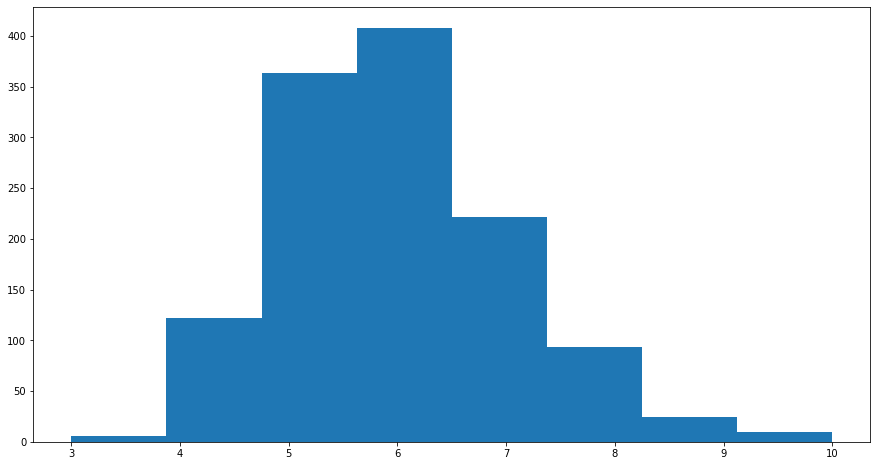

In [18]:
fig, ax = plt.subplots(figsize = (15, 8))

ax.hist(seattle['grades'], bins=8)

(array([  3.,  23., 128., 392., 448., 236.,  55.,   3.]),
 array([ 3.   ,  3.875,  4.75 ,  5.625,  6.5  ,  7.375,  8.25 ,  9.125,
        10.   ]),
 <BarContainer object of 8 artists>)

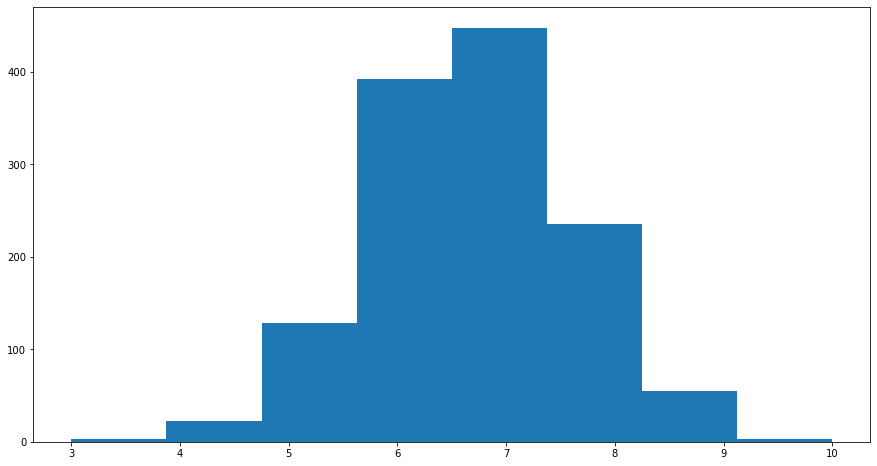

In [19]:
fig, ax = plt.subplots(figsize = (15, 8))

ax.hist(outside['grades'], bins=8)

In [20]:
seattle['grades'].describe()

count    1247.000000
mean        5.914996
std         1.223430
min         3.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: grades, dtype: float64

In [21]:
outside['grades'].describe()

count    1288.000000
mean        6.709627
std         1.091537
min         3.000000
25%         6.000000
50%         7.000000
75%         7.000000
max        10.000000
Name: grades, dtype: float64

Based on the analysis above, we conclude that the Seattle location is more lucrative than the Outside location, and that is why houses are more expensive on average despite having less square footage and lower grades.

**Year Built, Condition, and Renovation effects on Price**

Next, we take a look at variables that were less highly correlated with price of houses in the whole sample, to see if there is any relationship between them in the high value sample.

In [22]:
target_df['yr_built'].describe()

count    3000.000000
mean     1973.708333
std        32.524594
min      1900.000000
25%      1951.000000
50%      1983.000000
75%      2001.250000
max      2015.000000
Name: yr_built, dtype: float64

In [23]:
target_df['yr_built'].value_counts()

2014    159
2006     90
2007     78
2001     73
2008     68
       ... 
1935      4
1903      3
1934      2
1901      2
1944      2
Name: yr_built, Length: 116, dtype: int64

In [24]:
target_df['condition'].value_counts()

2.0    1951
3.0     705
4.0     337
1.0       6
0.0       1
Name: condition, dtype: int64

In [25]:
condition_prices = target_df.groupby("condition")["price"].mean()

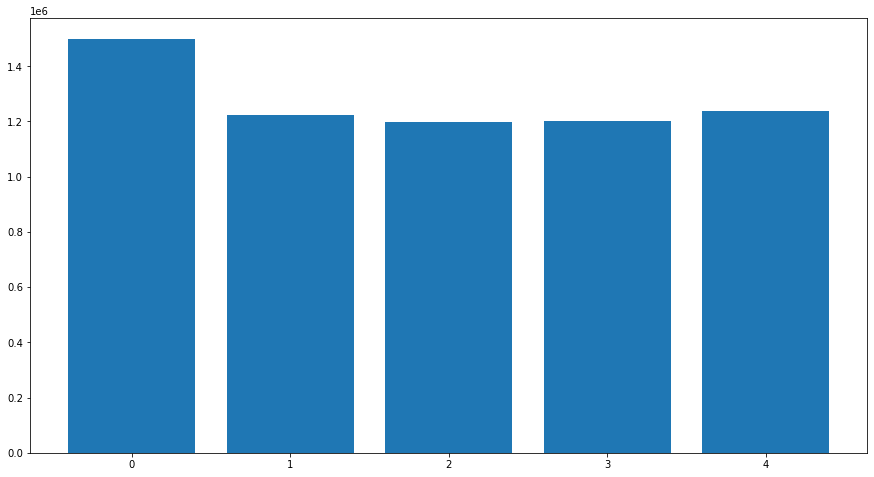

In [26]:
#average price per 'condition' value 
fig, ax = plt.subplots(figsize = (15, 8))

ax.bar(x = condition_prices.index, height = condition_prices);

Here, we find that houses of all Conditions sell for similar prices among the high value houses.

In [27]:
condition_avg_years_built = target_df.groupby("condition")["yr_built"].mean()
condition_avg_years_built

condition
0.0    1955.000000
1.0    1946.666667
2.0    1984.705279
3.0    1958.529078
4.0    1942.335312
Name: yr_built, dtype: float64

Interestingly, houses in the best Condition are older than houses in Average Condition

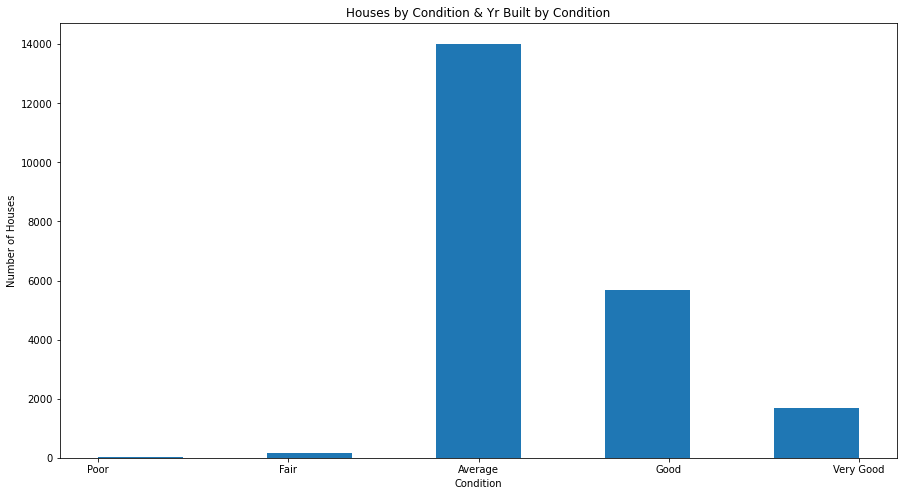

In [28]:
fig, ax = plt.subplots(figsize = (15, 8))

ax.hist(df['condition'], bins = 9)
ax.set_xticks([0, 1, 2, 3, 4])
plt.xlabel('Condition')
plt.xticks([0, 1, 2, 3, 4], ['Poor', 'Fair', 'Average', 'Good', 'Very Good'])
plt.ylabel('Number of Houses')
plt.title('Houses by Condition & Yr Built by Condition');

In [29]:
#separate by houses that are and are not renovated
renovated = target_df.loc[target_df['yr_renovated'] > 0]
not_renovated = target_df.loc[target_df['yr_renovated'] == 0]

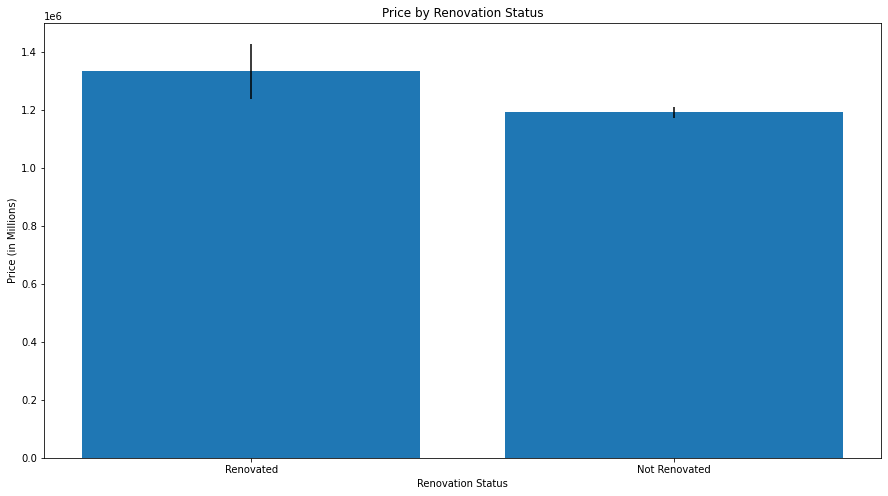

In [30]:
#average price per 'condition' value 
fig, ax = plt.subplots(figsize = (15, 8))

x_vals = ['Renovated', 'Not Renovated']
y_vals = [renovated['price'].mean(), not_renovated['price'].mean()]
y_stds = [renovated['price'].std()/np.sqrt(renovated['price'].shape[0])*1.96, not_renovated['price'].std()/np.sqrt(not_renovated['price'].shape[0])*1.96] 

plt.bar(x_vals, y_vals, yerr=y_stds)
plt.xlabel('Renovation Status')
plt.ylabel('Price (in Millions)')
plt.title('Price by Renovation Status');

Here we see that Renovated houses sell for more than houses without renovations in this price range. A 2 sample t-test below verifies this to be significant of the whole groups.

In [31]:
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import t
import pandas as pd

def welch_ttest(x1, x2):
    
    n1 = x1.size
    n2 = x2.size
    m1 = np.mean(x1)
    m2 = np.mean(x2)
    
    v1 = np.var(x1, ddof=1)
    v2 = np.var(x2, ddof=1)
    
    pooled_se = np.sqrt(v1 / n1 + v2 / n2)
    delta = m1-m2
    
    tstat = delta /  pooled_se
    df = (v1 / n1 + v2 / n2)**2 / (v1**2 / (n1**2 * (n1 - 1)) + v2**2 / (n2**2 * (n2 - 1)))
    
    # two side t-test
    p = 2 * t.cdf(-abs(tstat), df)
    
    # upper and lower bounds
    lb = delta - t.ppf(0.975,df)*pooled_se 
    ub = delta + t.ppf(0.975,df)*pooled_se
  
    return pd.DataFrame(np.array([tstat,df,p,delta,lb,ub]).reshape(1,-1),
                         columns=['T statistic','df','pvalue 2 sided','Difference in mean','lb','ub'])

In [32]:
welch_ttest(renovated['price'], not_renovated['price'])

,T statistic,df,pvalue 2 sided,Difference in mean,lb,ub
0,2.809963,275.258961,0.00531,140405.420379,42039.396875,238771.443884


In [33]:
target_df['yr_renovated'].value_counts()

0.0       2745
2014.0      20
2007.0      16
2005.0      14
2003.0      14
2000.0      14
2013.0      11
2002.0      10
2004.0       9
1999.0       9
2006.0       9
1990.0       8
2010.0       8
2009.0       8
2008.0       8
2015.0       7
1991.0       7
2001.0       7
1993.0       6
1998.0       6
1994.0       5
1989.0       5
1995.0       5
1985.0       4
1992.0       4
1988.0       4
1996.0       4
1987.0       4
1997.0       3
1984.0       3
2012.0       3
1956.0       2
1983.0       2
1982.0       2
1980.0       2
1979.0       2
1954.0       1
1968.0       1
1986.0       1
1962.0       1
1965.0       1
1963.0       1
1970.0       1
1977.0       1
1958.0       1
2011.0       1
Name: yr_renovated, dtype: int64

In [34]:
renovations_df = target_df.loc[target_df['yr_renovated'] >= 1954]

In [35]:
renovated_prices = renovations_df.groupby("yr_renovated")["price"].mean()

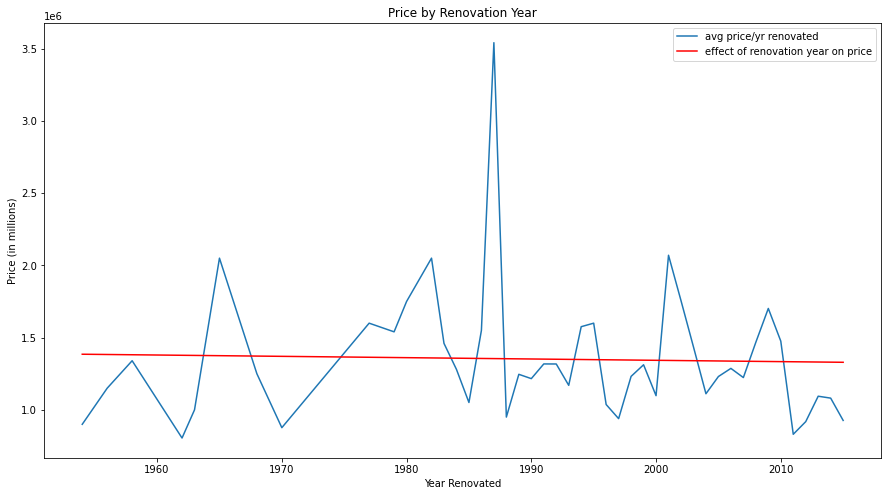

''

In [36]:
fig, ax = plt.subplots(figsize = (15, 8))

ax.plot(renovated_prices, label='avg price/yr renovated')
theta = np.polyfit(renovated_prices.index, renovated_prices, 1)
y_line = theta[1] + theta[0] * renovated_prices.index
plt.plot(renovated_prices.index, y_line, 'r', label ='effect of renovation year on price')
plt.xlabel('Year Renovated')
plt.ylabel('Price (in millions)')
plt.title('Price by Renovation Year')
plt.legend()
plt.show()
;

Though Renovation status has an effect on sale price, here we find that the year of renovations has little effect on the sale price of a house. Surprisingly, the line of best fit suggests that the more recently a home has been renovated, the less it will sell for.

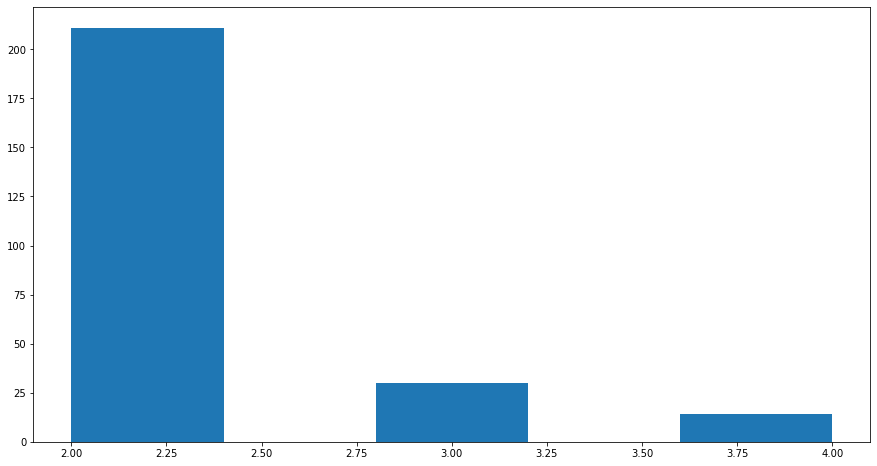

In [37]:
fig, ax = plt.subplots(figsize = (15, 8))

ax.hist(renovated['condition'], bins = 5);

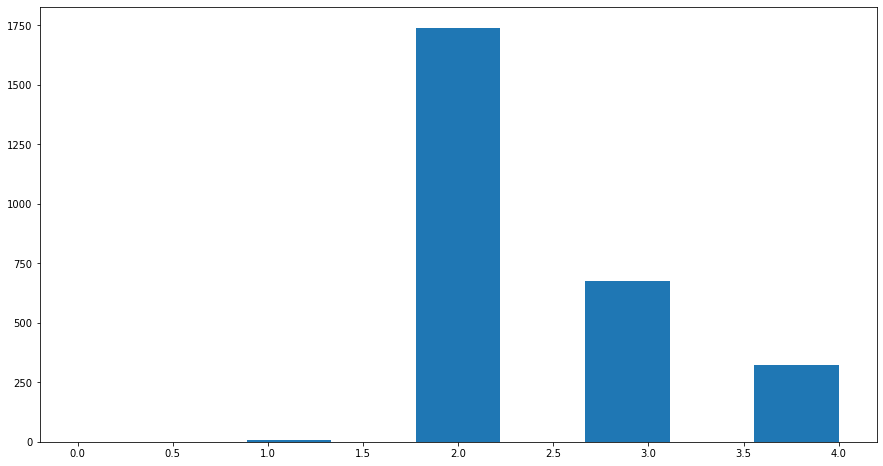

In [38]:
fig, ax = plt.subplots(figsize = (15, 8))

ax.hist(not_renovated['condition'], bins = 9);

These graphs show us that whether a house has been renovated has little effect on its Condition

Text(0.5, 1.0, 'Year Built')

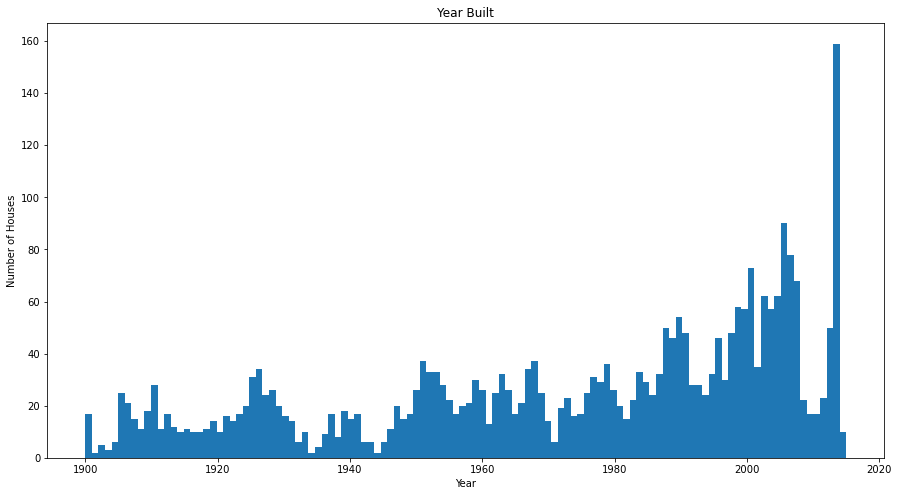

In [39]:
#distribution of high value houses by Year Built
fig, ax = plt.subplots(figsize = (15, 8))

ax.hist(target_df['yr_built'], bins = 116);
plt.xlabel('Year')
plt.ylabel('Number of Houses')
plt.title('Year Built')

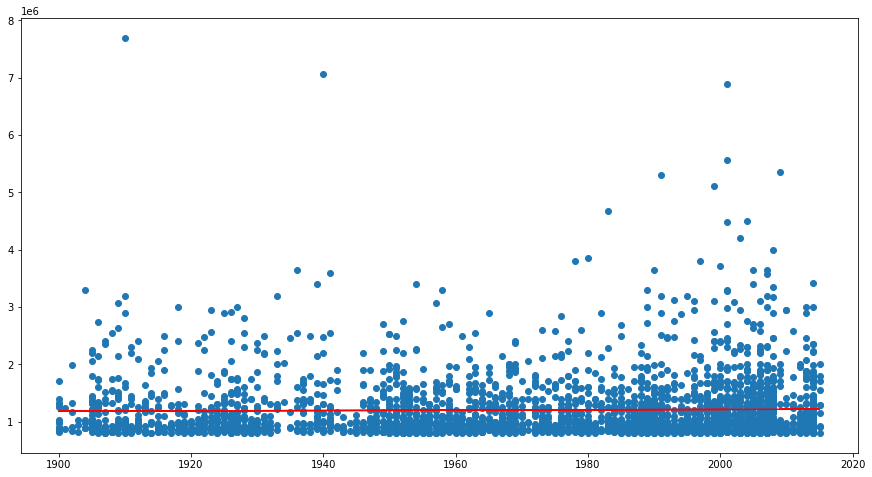

In [40]:
#scatter plot w line of best fit
fig, ax = plt.subplots(figsize = (15, 8))

ax.scatter(x = target_df['yr_built'], y = target_df['price']);
theta = np.polyfit(target_df['yr_built'], target_df['price'], 1)
y_line = theta[1] + theta[0] * target_df['yr_built']
plt.plot(target_df['yr_built'], y_line, 'r')

In [41]:
year_built_prices = target_df.groupby("yr_built")["price"].mean()

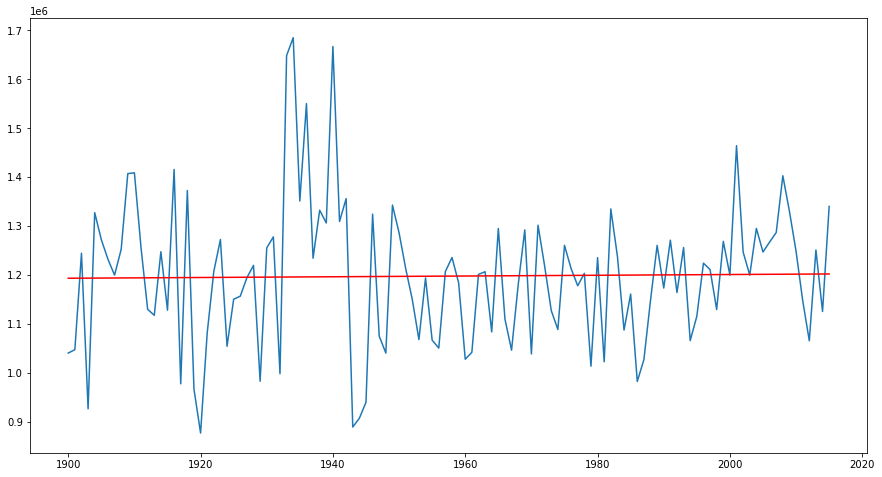

In [42]:
fig, ax = plt.subplots(figsize = (15, 8))

ax.plot(year_built_prices)
theta = np.polyfit(year_built_prices.index, year_built_prices, 1)
y_line = theta[1] + theta[0] * year_built_prices.index
plt.plot(year_built_prices.index, y_line, 'r');

This line graph of average sale price by year built and a line of best fit show there is no relationship between year built and price of houses in this sample.

**Investigate relationship between price and grades**

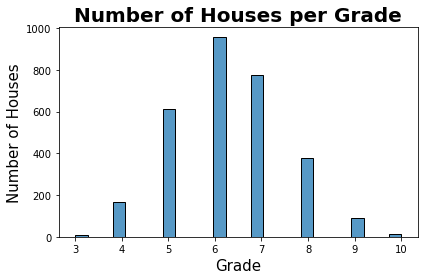

In [43]:
sns.histplot(target_df['grades'])
plt.title('Number of Houses per Grade', fontsize =20, weight = 'bold')
plt.ylabel('Number of Houses', fontsize =15)
plt.xlabel('Grade', fontsize =15)
plt.tight_layout();

In [44]:
# grades for target housing market appears mostly normally distributed. 
# the majority of the houses have grades between 6 and 7

In [45]:
target_grades_mean = target_df.groupby('grades')['price'].mean()
target_grades_mean

grades
3.0     9.739091e+05
4.0     9.245640e+05
5.0     1.002244e+06
6.0     1.079464e+06
7.0     1.256389e+06
8.0     1.540967e+06
9.0     2.202528e+06
10.0    3.710769e+06
Name: price, dtype: float64

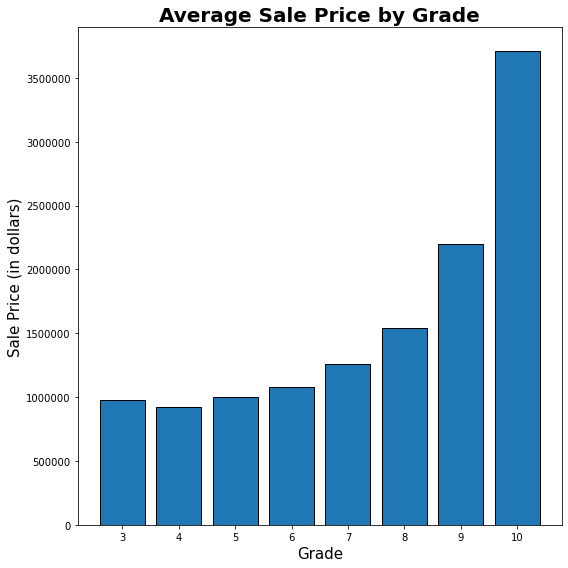

In [46]:
fig, ax = plt.subplots(figsize = (8, 8))


ax.bar(x = target_grades_mean.index, height = target_grades_mean, edgecolor ='black')
plt.ticklabel_format(style='plain', axis = 'y')
plt.title('Average Sale Price by Grade', fontsize =20, weight = 'bold')
plt.ylabel('Sale Price (in dollars)', fontsize =15)
plt.xlabel('Grade', fontsize =15)
plt.tight_layout();

In [47]:
# as shown in the LR model, the sale price increases as grade increases. 

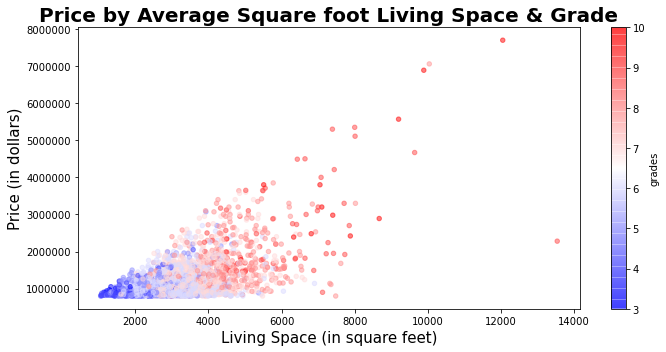

In [48]:
fig, ax = plt.subplots(figsize=(10,5))
target_df.plot.scatter(x="sqft_living", y="price", c='grades', cmap="bwr", alpha=0.5, ax=ax);
plt.title('Price by Average Square foot Living Space & Grade', fontsize =20, weight = 'bold')
plt.ylabel(('Price (in dollars)'), fontsize =15)
plt.xlabel(('Living Space (in square feet)'), fontsize =15)
plt.ticklabel_format(style='plain', axis = 'y')
plt.tight_layout();

Sales price, square feet of living space and grade appear to highly related. Based on the graph as squarefoot increases both the price and grade.

## Going to look into the relationship between price, sqft_living, bedrooms, and bathrooms.

In [49]:
highend_800 = target_df

In [50]:
highend_800['bathrooms'].mean()

2.89775

In [51]:
highend_800['bedrooms'].mean()

3.966666666666667

In [52]:
highend_800['sqft_living'].mean()

3372.903

Creating 3 variables that will sort all three relationships buy the average price so we can graph them.

In [53]:
price_bath = highend_800.groupby('bathrooms')['price'].mean()
price_bed = highend_800.groupby('bedrooms')['price'].mean()
price_sqft = highend_800.groupby('sqft_living')['price'].mean()

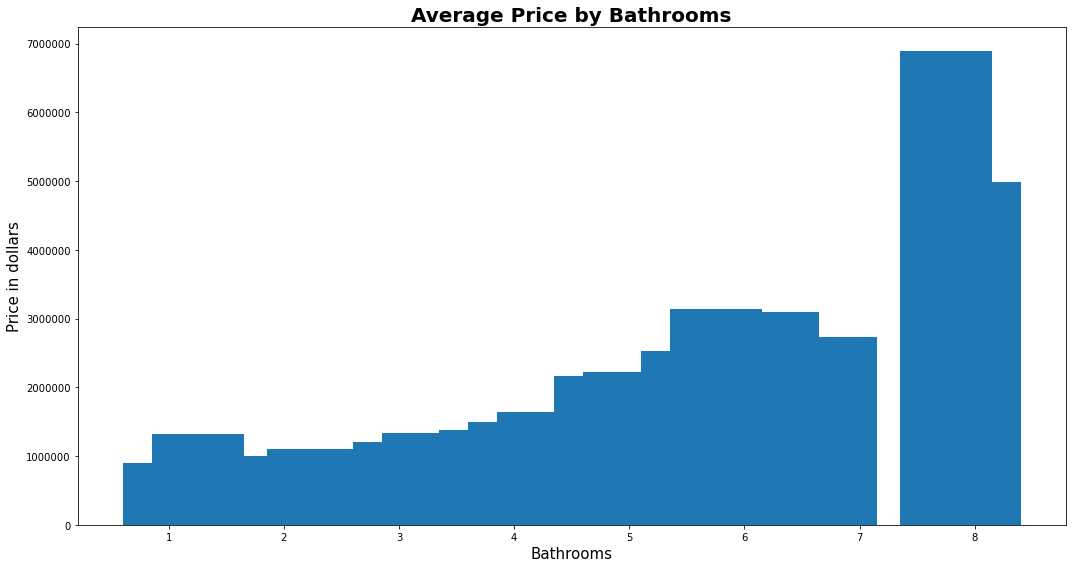

In [54]:
fig, ax = plt.subplots(figsize = (15, 8))
ax.bar(x = price_bath.index, height = price_bath);
plt.title('Average Price by Bathrooms', fontsize =20, weight = 'bold')
plt.ylabel(('Price in dollars'), fontsize =15)
plt.xlabel(('Bathrooms'), fontsize =15)
plt.ticklabel_format(style='plain', axis = 'y')
plt.tight_layout();

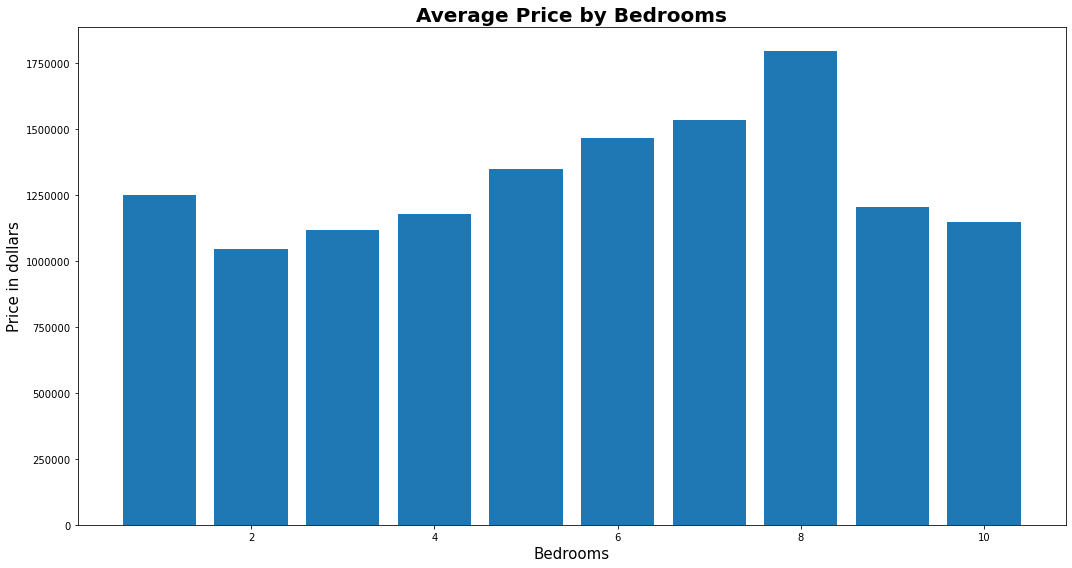

In [55]:
fig, ax = plt.subplots(figsize = (15, 8))
ax.bar(x = price_bed.index, height = price_bed);
plt.title('Average Price by Bedrooms', fontsize =20, weight = 'bold')
plt.ylabel(('Price in dollars'), fontsize =15)
plt.xlabel(('Bedrooms'), fontsize =15)
plt.ticklabel_format(style='plain', axis = 'y')
plt.tight_layout();

In [56]:
y = highend_800['price']
X = highend_800.drop('price', axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Testing the linear regression modle on just the bedrooms, bathrooms, and sqft_living.

In [57]:
relevant_columns = [    
 'bedrooms',    
 'bathrooms',  
 'sqft_living'  
#  'sqft_lot',    
#  'floors',    
#  'waterfront', 
#  'condition',
#  'grades',
#  'sqft_above',
#  'sqft_basment_calc',
#  'yr_built',
#  'yr_renovated',
#  'zipcode',
#  'lat',
#  'long',
#  'sqft_living15',
#  'sqft_lot15'
]

In [58]:
X_train = X_train.loc[:, relevant_columns]
lr = LinearRegression()
lr.fit(X_train, y_train)
cross_val_score(lr, X_train, y_train, cv=3)

array([0.31911078, 0.32169367, 0.39448431])

In [59]:
X_test = X_test.loc[:, relevant_columns]

In [60]:
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.31230596757467466

In [61]:
y = highend_800['price']
X = highend_800.loc[:, relevant_columns]
results_grade = sm.OLS(y, sm.add_constant(X)).fit()
results_grade.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     513.8
Date:                Sun, 07 Aug 2022   Prob (F-statistic):          2.23e-269
Time:                        20:14:05   Log-Likelihood:                -43278.
No. Observations:                3000   AIC:                         8.656e+04
Df Residuals:                    2996   BIC:                         8.659e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.452e+05   3.99e+04      8.655      0.000    2.67e+05    4.23e+05
bedrooms    -5.849e+04   1.03e+04     -5.669      0.000   -7.87e+04   -3.83e+04
bathrooms    4.788e+04   1.46e+04      3.275      0.001    1.92e+04    7.66e+04
sqft_living   282.0614     11.040     25.548      0.000     260.414     303.709
==============================================================================
Omnibus:                     1409.167   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13760.755
Skew:                           1.988   Prob(JB):                         0.00
Kurtosis:                      12.710   Cond. No.                     1.77e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.77e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This graph shows that the correlation between price and bedrooms isn't very signifiacnt.

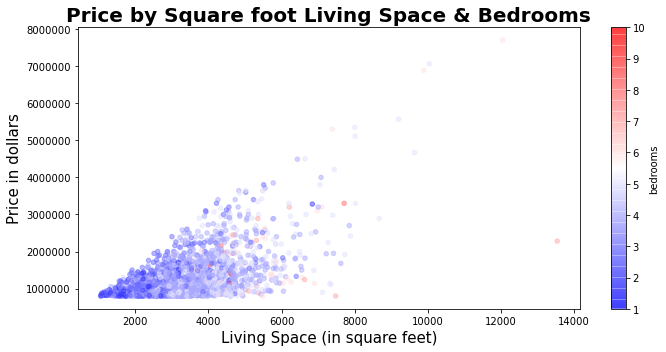

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib nbagg
%matplotlib inline

#highend_800["price"] = highend_800["price"] - highend_800["price"].mean()

fig, ax = plt.subplots(figsize=(10,5))
plt.ticklabel_format(style='plain', axis = 'y')
highend_800.plot.scatter(x="sqft_living", y="price", c='bedrooms', cmap="bwr", alpha=0.5, ax=ax);
plt.title('Price by Square foot Living Space & Bedrooms', fontsize =20, weight = 'bold')
plt.ylabel(('Price in dollars'), fontsize =15)
plt.xlabel(('Living Space (in square feet)'), fontsize =15)
plt.ticklabel_format(style='plain', axis = 'y')
plt.tight_layout();

This graph shows that the correlation between price and bathrooms is signifiacnt.

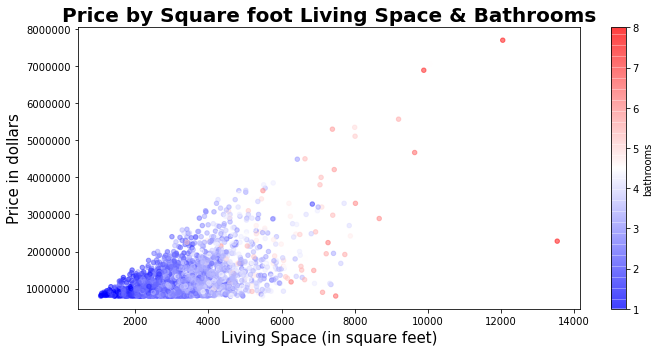

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib nbagg
%matplotlib inline

#highend_800["price"] = highend_800["price"] - highend_800["price"].mean()

fig, ax = plt.subplots(figsize=(10,5))
plt.ticklabel_format(style='plain', axis = 'y')
highend_800.plot.scatter(x="sqft_living", y="price", c='bathrooms', cmap="bwr", alpha=0.5, ax=ax);
plt.title('Price by Square foot Living Space & Bathrooms', fontsize =20, weight = 'bold')
plt.ylabel(('Price in dollars'), fontsize =15)
plt.xlabel(('Living Space (in square feet)'), fontsize =15)
plt.ticklabel_format(style='plain', axis = 'y')
plt.tight_layout();

We decided to take a look at the Square Foot compared to the price inside and outside of Seattle. 

In [78]:
inside = highend_800.loc[(highend_800['lat'] >= 47.6) & (highend_800['long'] <= -122.2)]

In [79]:
outside = highend_800.loc[(highend_800['long'] >= -122.2)]

In [80]:
long_test = highend_800.loc[highend_800['long'] <= -122.2]

In [81]:
upper = inside['sqft_living'].sum()/ inside['price'].sum()

In [75]:
lower = outside['sqft_living'].sum()/ outside['price'].sum()

We devided sum of all the sqft_living by the sum of all the price, for both inside and outside the city. then we took that result and divided the result of the inside by the result of the outside and found out that exactly how much more square foot you can get on average outside of the city.

In [77]:
upper / lower

0.6812795724938258